# Connect to folder

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully!")
    %tensorflow_version 2.x
except Exception as e:
    print("Error while mounting Google Drive: {}".format(str(e)))

Mounted at /content/drive
Google Drive mounted successfully!


In [ ]:
import os 
path_to_drive = '/content/drive/MyDrive/Capstone Project files/Matt_folder' 
os.chdir(path_to_drive)
print(os.getcwd()) 

/content/drive/.shortcut-targets-by-id/17ASRcCWPKR_C9EEaMjcaL9Z8sFgwVxkv/Capstone Project files/Matt_folder


# Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error,classification_report, roc_curve 

import re
from functools import reduce
from collections import Counter

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

%matplotlib inline

In [ ]:
#sequential
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
from keras.models import model_from_json

In [ ]:
from matplotlib import pyplot

# Load data

In [ ]:
def get_n_dummies():
    model_data=pd.read_csv('modeldata.csv')
    model_data=model_data.astype({'licensed':'category',"host_in_sfo":'category',
                               "host_is_superhost":'category',
                                "host_has_profile_pic":'category',"host_identity_verified":'category',
                              "instant_bookable":'category','neighbourhood_cleansed':'category',
                             'property_type':'category','room_type':'category',
                             'bathrooms_text':'category','bedrooms':'category'
                             })

    dummy_columns=['host_is_superhost','host_has_profile_pic','host_identity_verified',
               'neighbourhood_cleansed','property_type','room_type','bathrooms_text','bedrooms','instant_bookable','licensed',"host_in_sfo"]

    for i in dummy_columns:
        if len(model_data.groupby([i]).size())>2:
            encoded_data=pd.get_dummies(model_data,prefix=[i],columns=[i],drop_first=False)
    encoded_data=pd.get_dummies(model_data,drop_first=False)
    encoded_data.drop(['Unnamed: 0'],axis=1,inplace=True)
    return encoded_data

In [ ]:
encoded_data=get_n_dummies()
encoded_data.shape

(6340, 75)

# Visualization

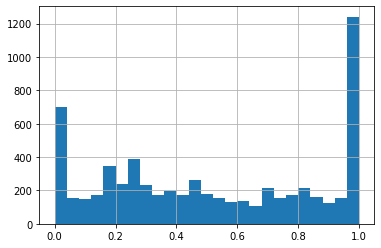

In [ ]:
# encoded_data['Success_rate'].hist(bins=25, figsize=(16,10)) # large 
encoded_data['Success_rate'].hist(bins=25, figsize=(6,4)) 
plt.show() 

## Correlation between target variable and predictors

*Not used in report*

In [ ]:
'''
pd.set_option('display.max_rows',None) # <<< is this needed? 
cols2drop = ['review_scores_rating', 'review_scores_location', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication']
correlation=encoded_data.drop(cols2drop, axis = 1).corr() 
''' 

"\npd.set_option('display.max_rows',None) # <<< is this needed? \ncols2drop = ['review_scores_rating', 'review_scores_location', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication']\ncorrelation=encoded_data.drop(cols2drop, axis = 1).corr() \n"

In [ ]:
'''
for a, b in correlation['Success_rate'].sort_values(ascending=False).head(11).iteritems():
   print(a+','+str(b))
# ^^^ write to file???     
''' 

"\nfor a, b in correlation['Success_rate'].sort_values(ascending=False).head(11).iteritems():\n   print(a+','+str(b))\n# ^^^ write to file???     \n"

In [ ]:
'''
for a, b in correlation['Success_rate'].sort_values(ascending=True).head(10).iteritems(): 
   print(a+','+str(b))   
# ^^^ write to file???       
''' 

"\nfor a, b in correlation['Success_rate'].sort_values(ascending=True).head(10).iteritems(): \n   print(a+','+str(b))   \n# ^^^ write to file???       \n"

# Partition the data

In [ ]:
# set minimum success rate for binary target variable  
min_success_rate = 0.50   

In [ ]:
# convert target variable to binary 
for i in encoded_data.index:
    if encoded_data.loc[i,'Success_rate']>min_success_rate: 
        encoded_data.loc[i,'Successful']=1
    else:
        encoded_data.loc[i,'Successful']=0
encoded_data.drop(['Success_rate'],axis=1,inplace=True)

X=encoded_data.drop(['Successful'],axis=1)
Y=encoded_data['Successful']

In [ ]:
X_train,X_valid,Y_train,Y_valid=train_test_split(X,Y,test_size=0.20,shuffle=True,random_state=1) 
X_train.shape,X_valid.shape 

((5072, 74), (1268, 74))

In [ ]:
#normalize the predictors
cols=X_train.columns
# scaler=preprocessing.MinMaxScaler()
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_valid=scaler.transform(X_valid)
X_train=pd.DataFrame(X_train,columns=cols)
X_valid=pd.DataFrame(X_valid,columns=cols)
X_train.describe() 

,host_response_time,host_response_rate,host_acceptance_rate,host_total_listings_count,accommodates,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_years,mean_price,top_amenities_count,host_verification_count,host_is_superhost_f,host_is_superhost_t,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,neighbourhood_cleansed_Group1,neighbourhood_cleansed_Group2,property_type_Entire condominium (condo),property_type_Entire guest suite,property_type_Entire loft,property_type_Entire rental unit,property_type_Entire residential home,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Private room in condominium (condo),property_type_Private room in guest suite,property_type_Private room in rental unit,property_type_Private room in residential home,property_type_Room in aparthotel,property_type_Room in boutique hotel,property_type_Room in hotel,property_type_Shared room in hostel,property_type_other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathrooms_text_bath group1,bathrooms_text_bath group2,bathrooms_text_bath group3,bathrooms_text_bath group4,bathrooms_text_bath group5,bedrooms_1.0,bedrooms_2.0,bedrooms_3.0,bedrooms_More than 3,instant_bookable_f,instant_bookable_t,host_in_sfo_0.0,host_in_sfo_1.0,licensed_0.0,licensed_1.0
count,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03,5.072000e+03
mean,3.669515e-16,-6.200788e-16,-1.718307e-17,5.833487e-18,1.154768e-16,4.793419e-16,-7.970972e-17,-2.297934e-16,4.520678e-17,1.171896e-16,-1.423677e-16,1.599858e-16,-1.412185e-16,6.571934e-16,-9.346712e-17,-5.907910e-17,-1.177314e-16,9.259155e-17,1.191870e-16,-6.549265e-17,2.603070e-16,5.233721e-17,1.457824e-17,8.320106e-17,-4.182161e-16,-3.994789e-16,4.177564e-17,-4.867295e-16,3.540587e-18,3.537304e-16,1.911808e-16,-7.354790e-18,9.473670e-17,3.204040e-17,2.138854e-16,-4.983746e-16,4.424256e-16,-3.742844e-16,3.742844e-16,2.171414e-16,6.309359e-16,5.446211e-16,4.160272e-16,1.738664e-16,-4.444504e-16,-2.643182e-16,2.230296e-16,6.088004e-16,-5.087938e-16,1.707471e-16,-2.248410e-16,-3.043591e-16,2.249012e-16,-8.919872e-17,3.645984e-16,5.656184e-17,1.174528e-15,-4.561283e-16,2.015223e-15,-7.157786e-17,-2.903172e-16,4.088913e-16,-2.741629e-16,-1.225273e-15,4.203613e-16,1.884227e-16,1.149186e-17,5.819040e-16,-9.981500e-17,9.981500e-17,3.096016e-16,-1.745011e-16,4.000261e-16,-2.505444e-16
std,1.000099e+00,1.000099e+00,1.000099e+00,1.000099e+00,1.000099e+00,1.000099e+00,1.000099e+00,1.000099e+00,1.000099e+00,1.000099e+00,1.000099e+00,1.000099e+00,1.000099e+

# DNN Binary Classification model

In [ ]:
''' 
# original model for reference 
model=Sequential()
model.add(Dense(16,input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(8,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model.add(Dense(1,activation='sigmoid'))

opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()
'''  

" \n# original model for reference \nmodel=Sequential()\nmodel.add(Dense(16,input_dim=X_train.shape[1], activation='relu'))\nmodel.add(Dense(8,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)))\nmodel.add(Dense(1,activation='sigmoid'))\n\nopt=tf.keras.optimizers.Adam(learning_rate=0.0001)\n\nmodel.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])\nmodel.summary()\n"

In [ ]:

model_binary=Sequential()
model_binary.add(Dense(16,input_dim=X_train.shape[1], activation='relu'))
model_binary.add(Dense(8,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model_binary.add(Dense(1,activation='sigmoid')) 

opt=tf.keras.optimizers.Adam(learning_rate=0.0001) 

model_binary.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model_binary.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                1200      
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,345
Trainable params: 1,345
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs=120

model_binary.reset_states()

model_binary_history=model_binary.fit(X_train,Y_train,epochs=num_epochs,batch_size=32,validation_data=(X_valid,Y_valid),verbose=2)
model_binary_history

Epoch 1/120
159/159 - 2s - loss: 0.7114 - accuracy: 0.5193 - val_loss: 0.6945 - val_accuracy: 0.5678 - 2s/epoch - 11ms/step
Epoch 2/120
159/159 - 0s - loss: 0.6995 - accuracy: 0.5394 - val_loss: 0.6887 - val_accuracy: 0.5875 - 230ms/epoch - 1ms/step
Epoch 3/120
159/159 - 0s - loss: 0.6917 - accuracy: 0.5574 - val_loss: 0.6845 - val_accuracy: 0.5875 - 224ms/epoch - 1ms/step
Epoch 4/120
159/159 - 0s - loss: 0.6859 - accuracy: 0.5741 - val_loss: 0.6811 - val_accuracy: 0.5899 - 209ms/epoch - 1ms/step
Epoch 5/120
159/159 - 0s - loss: 0.6811 - accuracy: 0.5840 - val_loss: 0.6780 - val_accuracy: 0.5923 - 232ms/epoch - 1ms/step
Epoch 6/120
159/159 - 0s - loss: 0.6770 - accuracy: 0.5915 - val_loss: 0.6755 - val_accuracy: 0.5931 - 204ms/epoch - 1ms/step
Epoch 7/120
159/159 - 0s - loss: 0.6734 - accuracy: 0.5998 - val_loss: 0.6730 - val_accuracy: 0.5883 - 224ms/epoch - 1ms/step
Epoch 8/120
159/159 - 0s - loss: 0.6699 - accuracy: 0.6031 - val_loss: 0.6707 - val_accuracy: 0.5938 - 247ms/epoch - 2ms

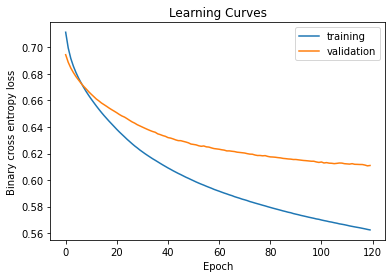

In [ ]:
# graph for report 
pyplot.figure(figsize=(6,4))
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Binary cross entropy loss')
pyplot.plot(model_binary_history.history['loss'], label='training')
pyplot.plot(model_binary_history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

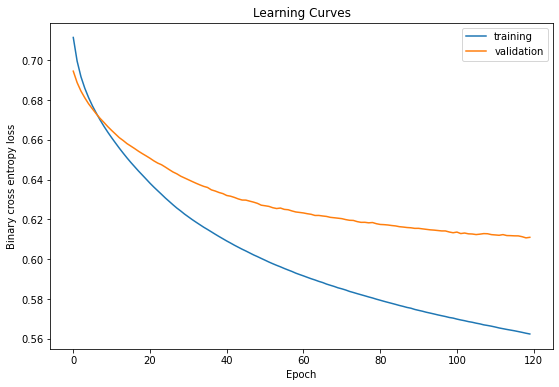

In [ ]:
# graph for slides  
pyplot.figure(figsize=(9,6))
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Binary cross entropy loss')
pyplot.plot(model_binary_history.history['loss'], label='training')
pyplot.plot(model_binary_history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

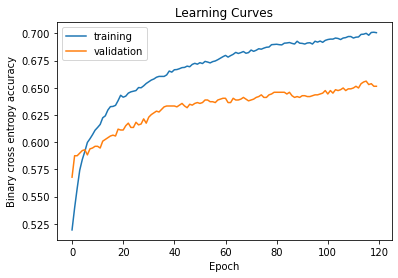

In [ ]:
# from matplotlib import pyplot

pyplot.figure(figsize=(6,4))
pyplot.title('Learning Curves')
pyplot.xlabel('Epoch')
pyplot.ylabel('Binary cross entropy accuracy')
pyplot.plot(model_binary_history.history['accuracy'], label='training')
pyplot.plot(model_binary_history.history['val_accuracy'], label='validation')
pyplot.legend()
pyplot.show()

In [ ]:
# serialize model to JSON
model_binary_json = model_binary.to_json()
with open("model_binary.json", "w") as json_file:
    json_file.write(model_binary_json)
# serialize weights to HDF5
model_binary.save_weights("model_binary.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# evaluate model on training data
model_binary.evaluate(X_train, Y_train,verbose=2)

159/159 - 0s - loss: 0.5613 - accuracy: 0.7005 - 141ms/epoch - 889us/step


[0.5612881779670715, 0.7005126476287842]

In [ ]:
# evaluate model on validation data 
model_binary.evaluate(X_valid, Y_valid,verbose=2)

40/40 - 0s - loss: 0.6110 - accuracy: 0.6514 - 52ms/epoch - 1ms/step


[0.6109926104545593, 0.6514195799827576]

# Compare binary to naive model 

*Not included in report*

In [ ]:
# get average success rate on training data 
train_success = Y_train.sum() 
print('total successful on training data:')
print(train_success) 

total successful on training data:
2414.0


In [ ]:
# get average success rate on validation data 
valid_success = Y_valid.sum() 
print('total successful on validation data:')
print(valid_success) 

total successful on validation data:
641.0


In [ ]:
# naive model on training 
train_all = train_success / Y_train.shape[0] 
train_none = 1 - train_all

# naive model on validation 
valid_all = valid_success / Y_valid.shape[0] 
valid_none = 1 - valid_all

# print most accurate 
if train_all > train_none: 
  print('accuracy if guess all successful') 
  print('training\t', train_all) 
  print('validation\t', valid_all) 
else: 
  print('accuracy if guess none successful')
  print('training\t', train_none) 
  print('validation\t', valid_none)  

accuracy if guess none successful
training	 0.5240536277602523
validation	 0.49447949526813884


# Run binary model on validation data

[Predicting with a Neural Network explained](https://youtu.be/Z0KVRdE_a7Q)

In [ ]:
X_valid.shape,Y_valid.shape

((1268, 74), (1268,))

In [ ]:
predictions_binary = model_binary.predict(X_valid, batch_size=32, verbose=2) 

40/40 - 0s - 66ms/epoch - 2ms/step


In [ ]:
predictions_binary_list = [round(n[0]) for n in predictions_binary]

In [ ]:
# convert test results to dataframe 
predictions_data = {'prediction': predictions_binary_list,
                    'actual': list(Y_valid)} 

In [ ]:
test_results_df = pd.DataFrame(predictions_data) 

In [ ]:
test_results_df['actual'] = test_results_df['actual'].astype(int) 

In [ ]:
test_results_df.head(10) 

,prediction,actual
0,0,0
1,1,1
2,0,0
3,1,1
4,1,0
5,1,1
6,0,0
7,1,0
8,1,1
9,1,1


In [ ]:
true_positive = 0
true_negative = 0 
false_positive = 0
false_negative = 0 
for i, r in test_results_df.iterrows():
  if r['prediction']==r['actual']==1:
    true_positive += 1
  if r['prediction']==r['actual']==0:
    true_negative += 1
  if r['prediction']==1 and r['actual']==0:
    false_positive += 1
  if r['prediction']==0 and r['actual']==1:
    false_negative += 1  

In [ ]:
count = true_positive + true_negative + false_positive + false_negative
if count != test_results_df.shape[0]:
  print('input error')
else: 
  print('no error') 

no error


In [ ]:
print('true positives\t{0:.2%}'.format(true_positive/count)) 
print('true negatives\t{0:.2%}'.format(true_negative/count))
print('false positives\t{0:.2%}'.format(false_positive/count))
print('false negatives\t{0:.2%}'.format(false_negative/count))


true positives	28.79%
true negatives	36.36%
false positives	13.09%
false negatives	21.77%


In [ ]:
print('true positives\t', true_positive) 
print('true negatives\t', true_negative) 
print('false positives\t', false_positive) 
print('false negatives\t', false_negative) 

true positives	 365
true negatives	 461
false positives	 166
false negatives	 276


In [ ]:
# confusion matrix
from sklearn import metrics
metrics.confusion_matrix(list(Y_valid), predictions_binary_list)


array([[461, 166],
       [276, 365]])

# Run binary model on entire dataset

*Not included in final report*

In [ ]:
X.shape,Y.shape

((6340, 74), (6340,))

In [ ]:
#normalize the predictors
cols=X.columns
# scaler=preprocessing.MinMaxScaler()
scaler=StandardScaler()
X_all=scaler.fit_transform(X)
X_all=pd.DataFrame(X_all,columns=cols)
X_all.describe()

,host_response_time,host_response_rate,host_acceptance_rate,host_total_listings_count,accommodates,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_since_years,mean_price,top_amenities_count,host_verification_count,host_is_superhost_f,host_is_superhost_t,host_has_profile_pic_f,host_has_profile_pic_t,host_identity_verified_f,host_identity_verified_t,neighbourhood_cleansed_Group1,neighbourhood_cleansed_Group2,property_type_Entire condominium (condo),property_type_Entire guest suite,property_type_Entire loft,property_type_Entire rental unit,property_type_Entire residential home,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Private room in condominium (condo),property_type_Private room in guest suite,property_type_Private room in rental unit,property_type_Private room in residential home,property_type_Room in aparthotel,property_type_Room in boutique hotel,property_type_Room in hotel,property_type_Shared room in hostel,property_type_other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,bathrooms_text_bath group1,bathrooms_text_bath group2,bathrooms_text_bath group3,bathrooms_text_bath group4,bathrooms_text_bath group5,bedrooms_1.0,bedrooms_2.0,bedrooms_3.0,bedrooms_More than 3,instant_bookable_f,instant_bookable_t,host_in_sfo_0.0,host_in_sfo_1.0,licensed_0.0,licensed_1.0
count,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03,6.340000e+03
mean,5.750045e-16,3.616193e-16,-1.854983e-16,3.770993e-16,1.353316e-15,-1.593153e-15,2.520819e-15,1.611995e-15,1.068156e-15,-3.050876e-15,2.703060e-15,-4.745372e-17,2.100953e-15,-3.026387e-16,-3.673788e-15,8.431741e-17,-1.961225e-15,2.723584e-15,3.000264e-15,-1.025398e-15,4.371337e-15,3.859864e-15,8.867775e-16,-1.989908e-15,9.683982e-16,7.644866e-16,-2.954874e-16,6.708019e-15,1.156541e-16,3.069819e-15,-2.114397e-15,1.057325e-14,-1.055346e-14,-1.961378e-15,1.982593e-15,-1.687171e-15,1.671639e-15,-2.023583e-15,2.031375e-15,-8.000435e-16,-2.895773e-15,1.207805e-16,-1.722807e-15,-2.964619e-15,3.337980e-15,-8.507872e-16,1.750265e-17,8.482305e-16,1.450294e-15,1.473847e-15,7.542643e-16,-5.214835e-15,8.168282e-16,6.498613e-16,8.143941e-16,1.675561e-15,-4.868840e-15,5.959481e-16,-1.355251e-15,-3.332105e-15,2.721395e-15,5.468987e-16,1.444901e-15,4.022479e-17,-1.481692e-15,-9.513245e-16,3.053901e-16,5.466623e-16,-1.010058e-15,1.010058e-15,2.659177e-15,-2.659877e-15,1.875184e-14,-1.875184e-14
std,1.000079e+00,1.000079e+00,1.000079e+00,1.000079e+00,1.000079e+00,1.000079e+00,1.000079e+00,1.000079e+00,1.000079e+00,1.000079e+00,1.000079e+00,1.000079e+00,1.000079e+0

In [ ]:
pred_bin_all = model_binary.predict(X_all, batch_size=32, verbose=2) 

199/199 - 0s - 132ms/epoch - 663us/step


In [ ]:
pred_bin_all_list = [round(n[0]) for n in pred_bin_all] 

In [ ]:
# convert test results to dataframe 
pred_data_all = {'prediction': pred_bin_all_list,
                    'actual': list(Y)} 

In [ ]:
results_all_df = pd.DataFrame(pred_data_all) 

In [ ]:
results_all_df['actual'] = results_all_df['actual'].astype(int) 

In [ ]:
results_all_df.head(10) 

,prediction,actual
0,0,1
1,1,0
2,0,0
3,0,0
4,1,0
5,0,0
6,1,0
7,0,1
8,1,0
9,1,1


In [ ]:
true_positive = 0
true_negative = 0 
false_positive = 0
false_negative = 0 
for i, r in results_all_df.iterrows():
  if r['prediction']==r['actual']==1:
    true_positive += 1
  if r['prediction']==r['actual']==0:
    true_negative += 1
  if r['prediction']==1 and r['actual']==0:
    false_positive += 1
  if r['prediction']==0 and r['actual']==1:
    false_negative += 1  

In [ ]:
count = true_positive + true_negative + false_positive + false_negative
if count != results_all_df.shape[0]:
  print('input error')
else: 
  print('no error') 

no error


In [ ]:
print('true positives\t{0:.2%}'.format(true_positive/count)) 
print('true negatives\t{0:.2%}'.format(true_negative/count))
print('false positives\t{0:.2%}'.format(false_positive/count))
print('false negatives\t{0:.2%}'.format(false_negative/count))


true positives	30.73%
true negatives	38.36%
false positives	13.45%
false negatives	17.46%
